# Read Me

## Run the code cells.
## You will then see the visualization part. First, click the full-screen button as shown below:
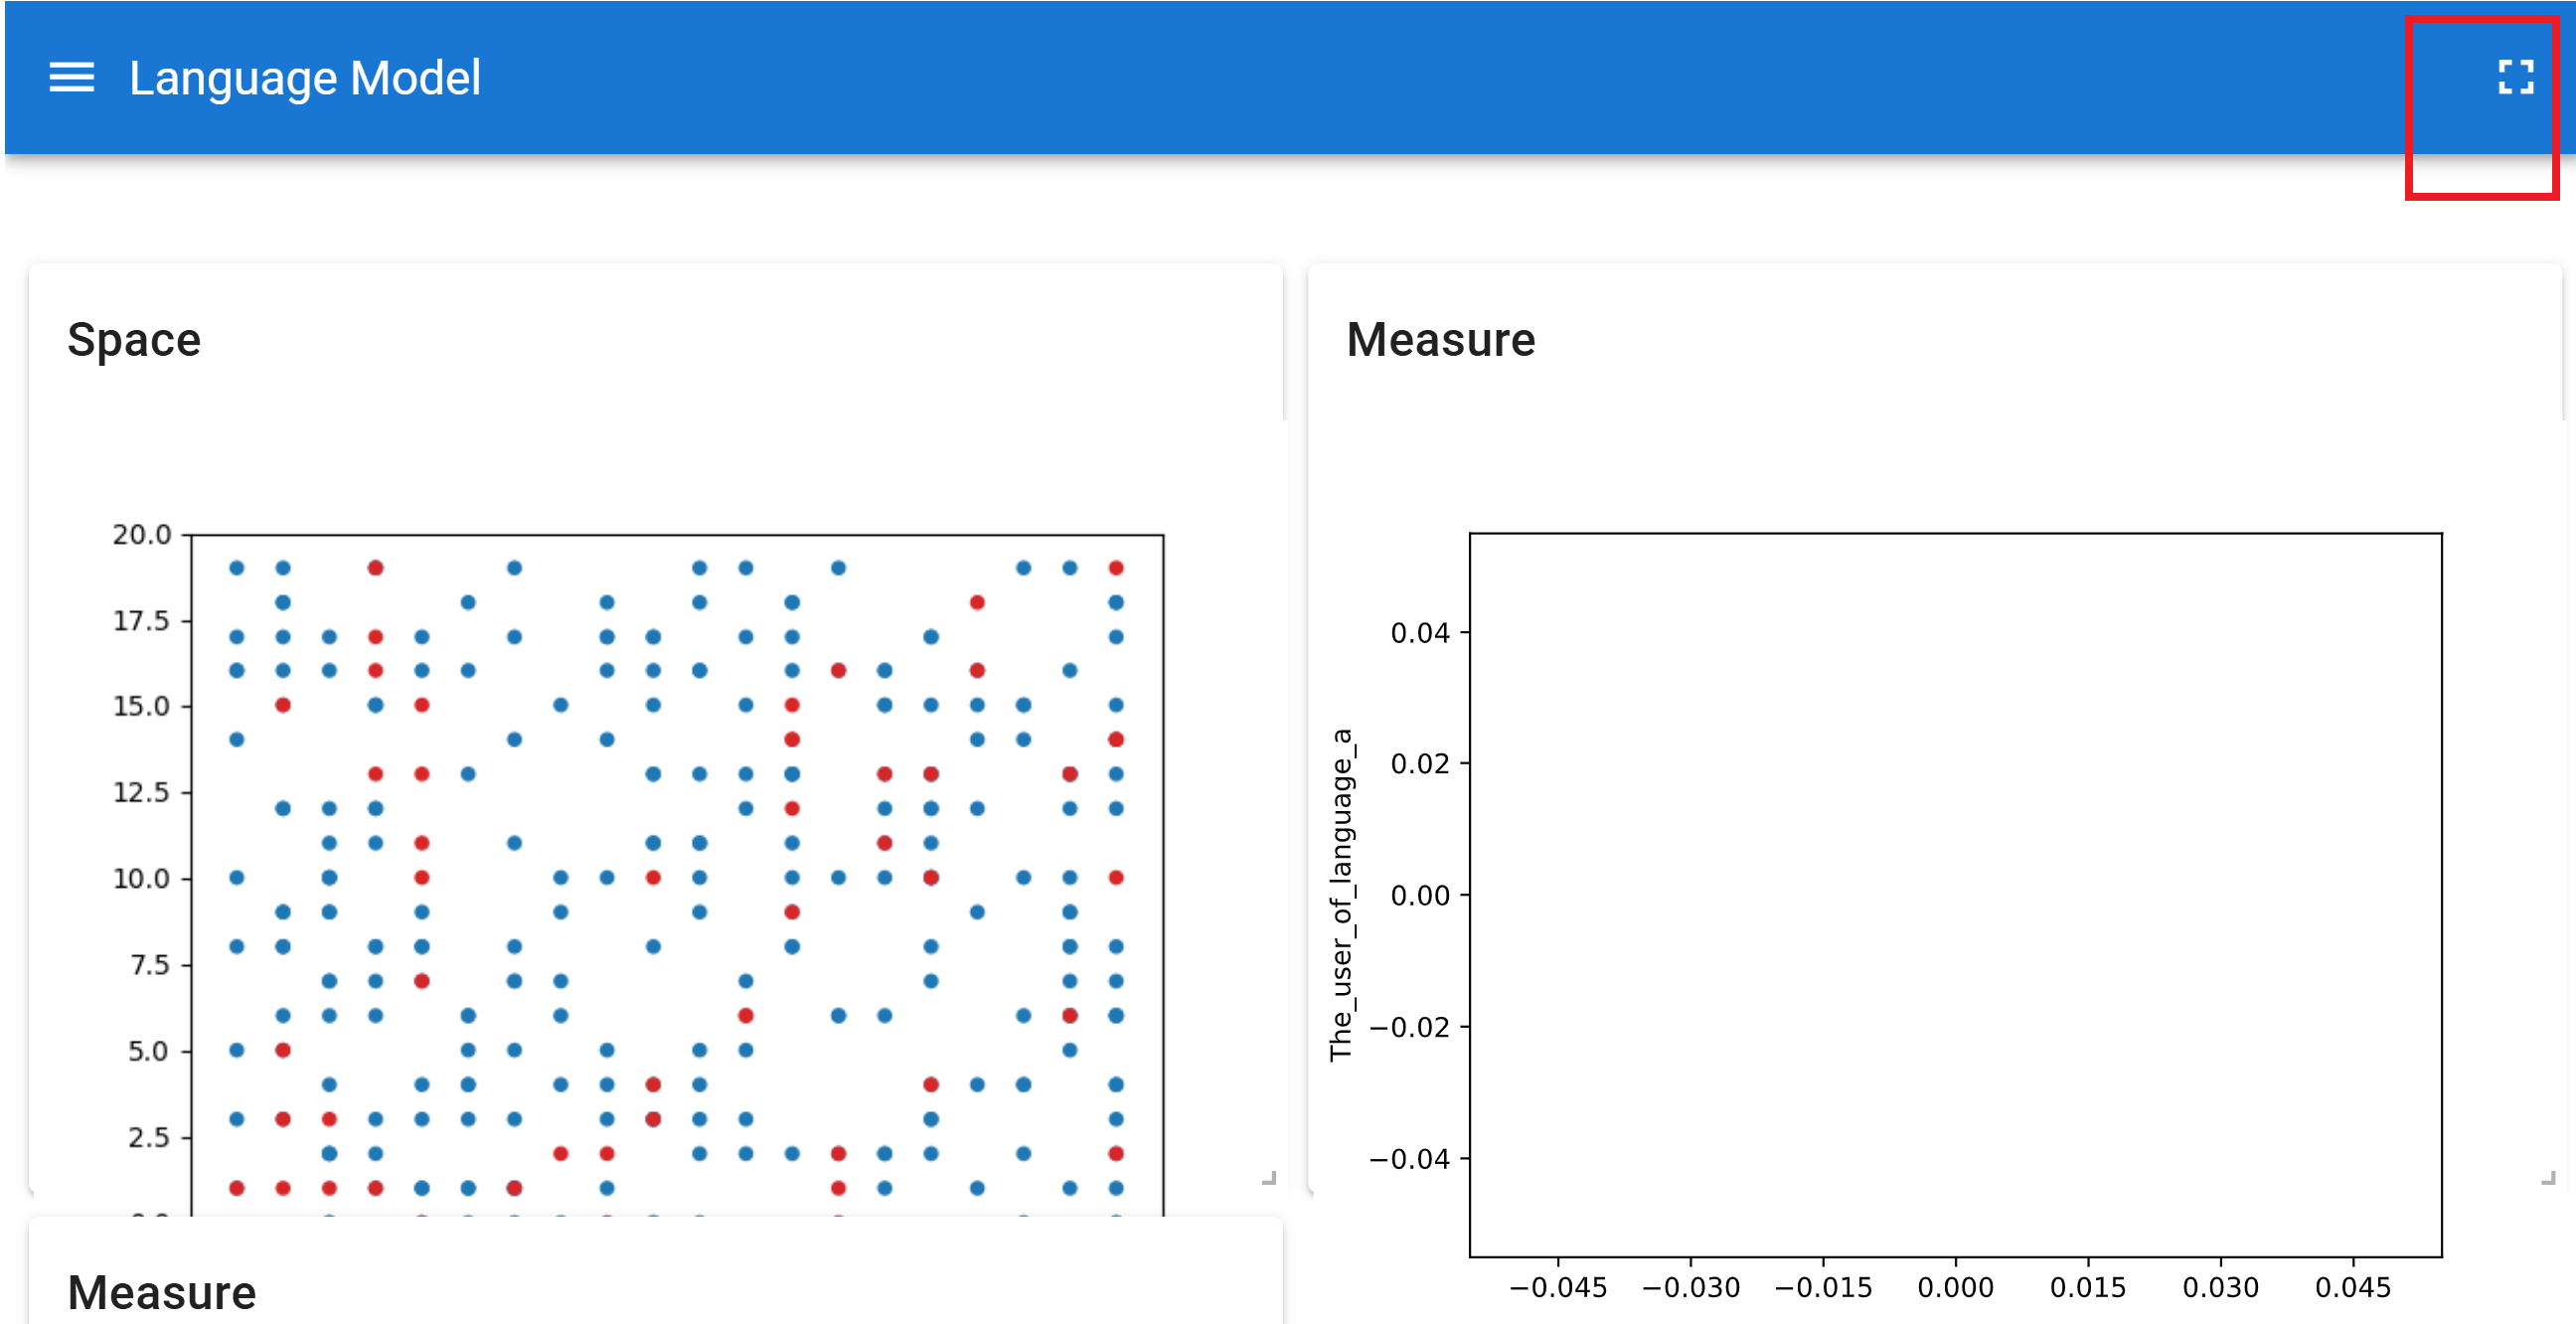

## Finally, click the option button to run the simulation and adjust the data by dragging the slider.
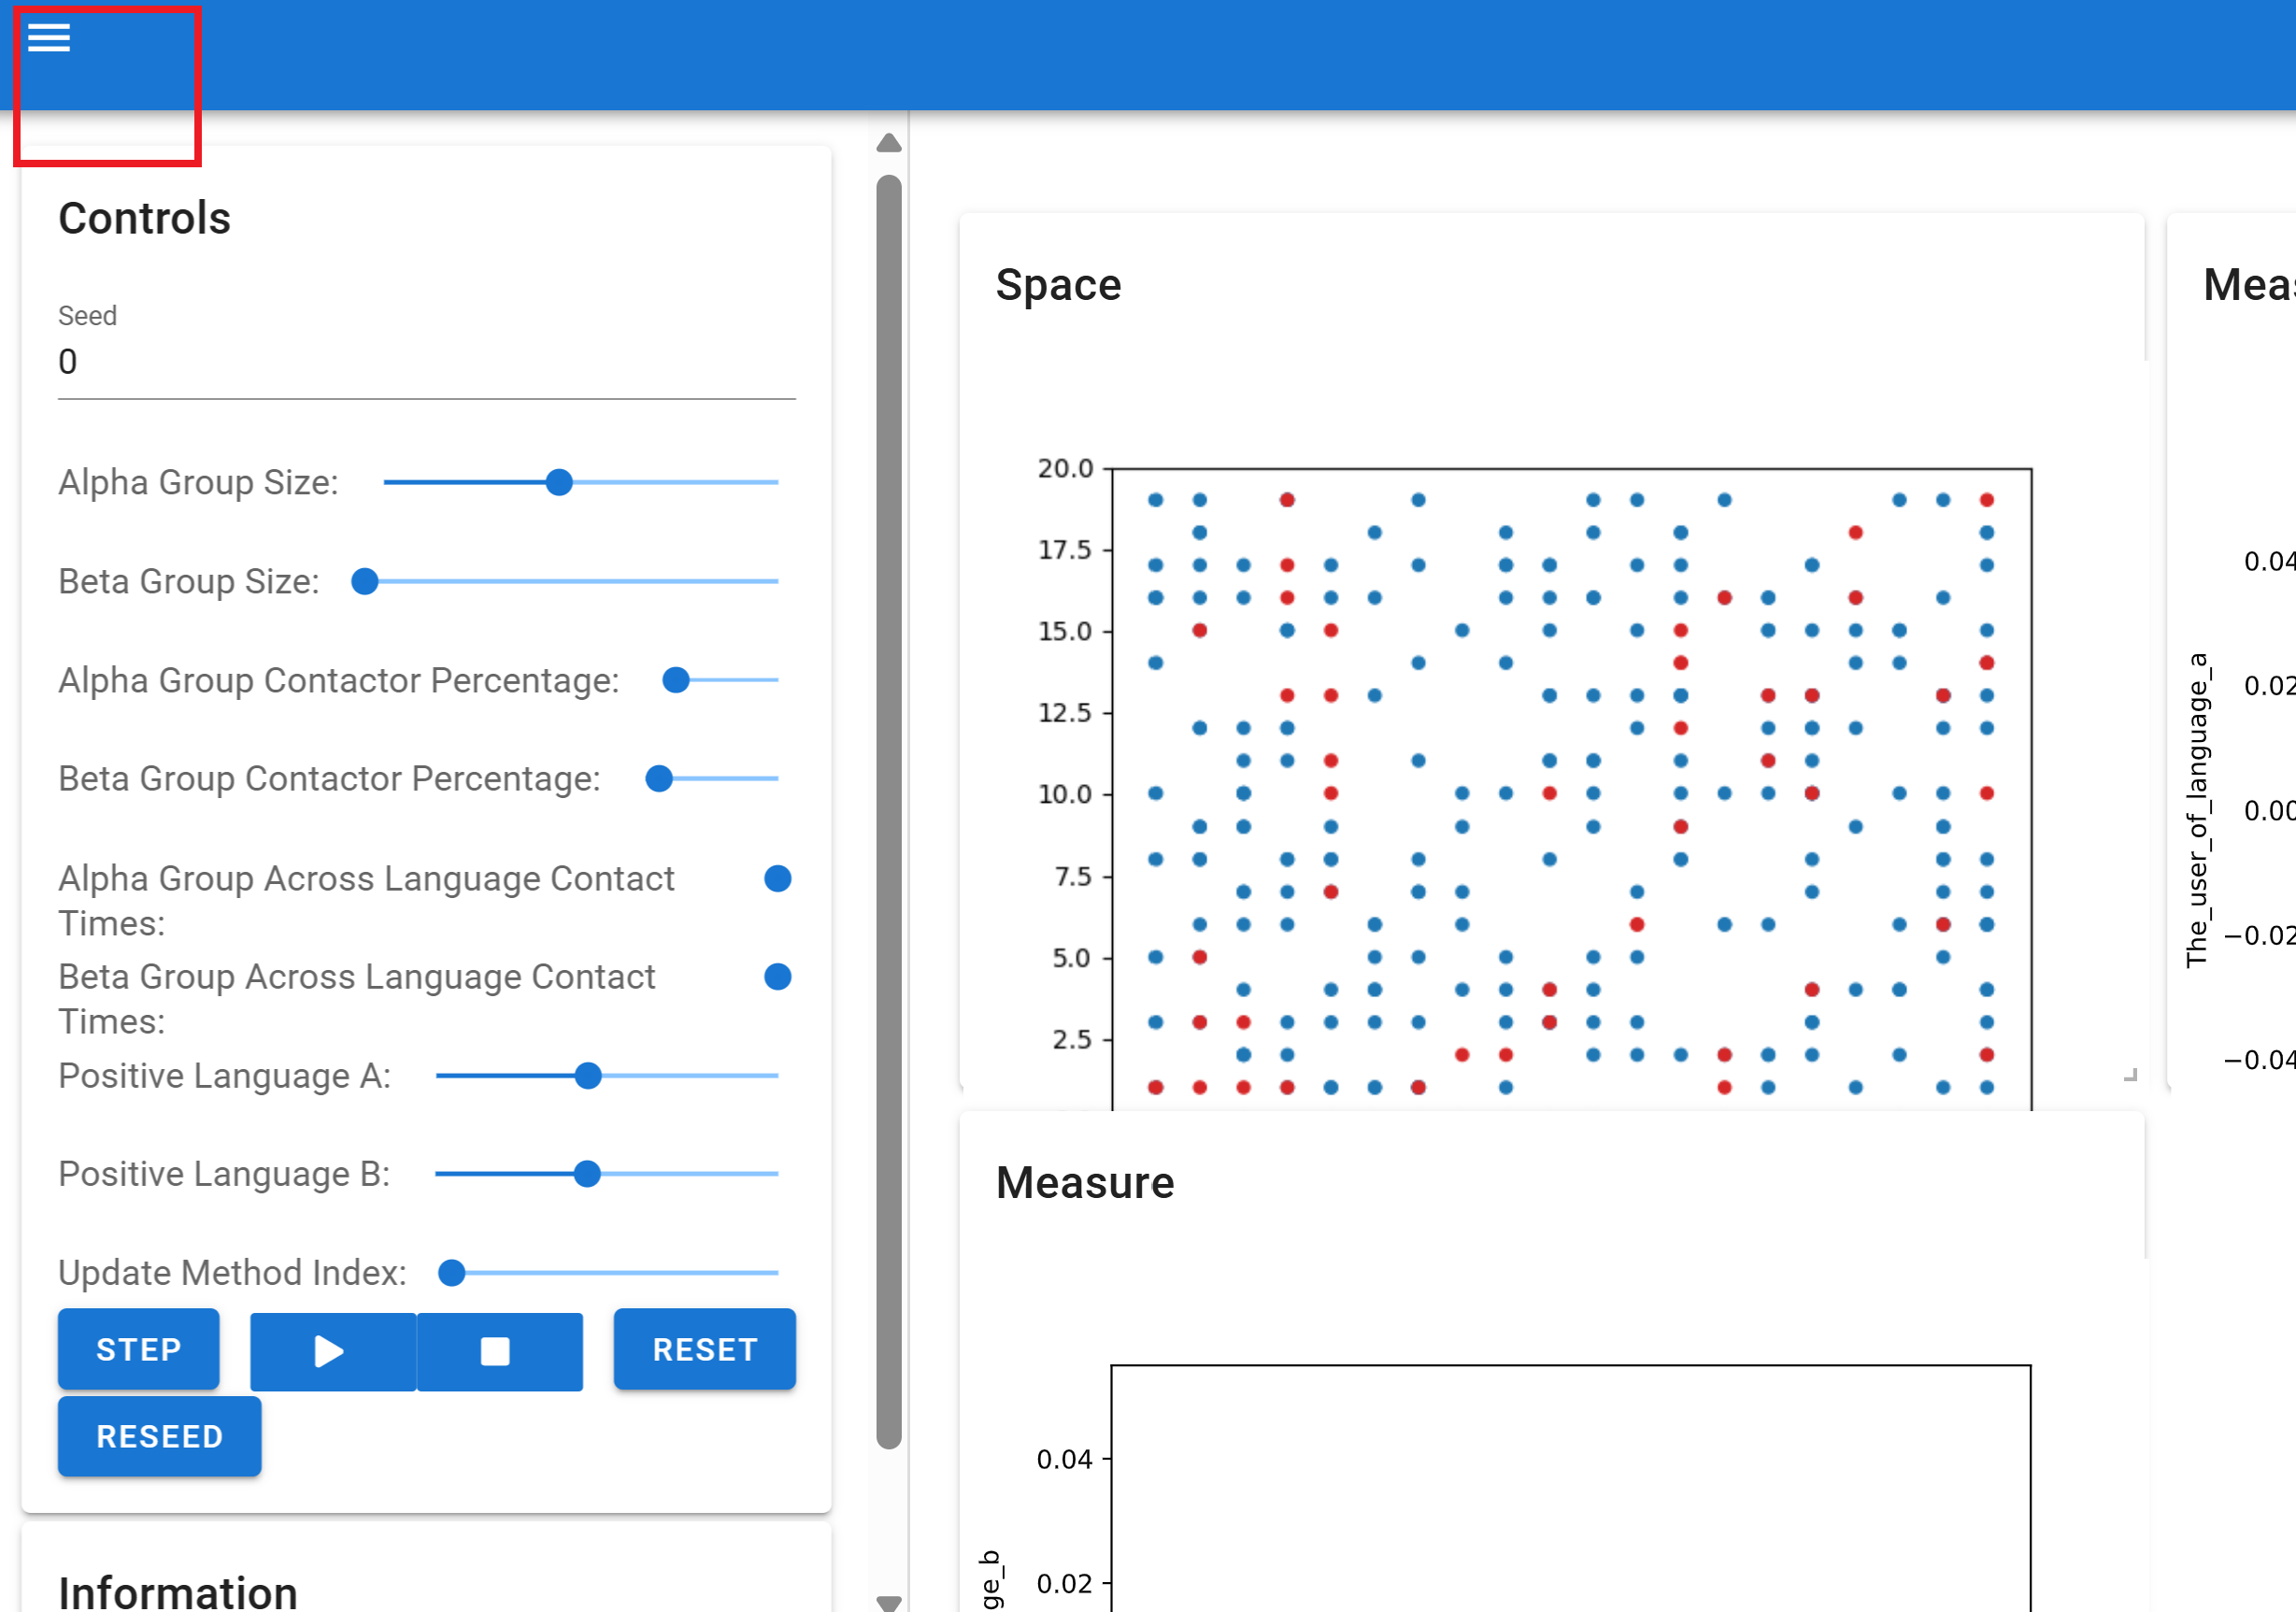

In [1]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd
import random
import multiprocessing as mp
# Create an agent portrayal function
from mesa.visualization import JupyterViz

In [2]:
def compute_language_a_user(model): # if the agent profiency in language a is larger than 0.5, then it can be seen as the user
    agent_language_a = [agent.language_a for agent in model.schedule.agents]
    count_a = 0
    for i in agent_language_a:
        if i>=0.5:
            count_a+=1
    return count_a
def compute_language_b_user(model):# if the agent profiency in language b is larger than 0.5, then it can be seen as the user
    agent_language_b = [agent.language_b for agent in model.schedule.agents]
    count_b = 0
    for i in agent_language_b:
        if i>=0.5:
            count_b+=1
    return count_b
    
            
class LanguageModel(mesa.Model):
    """A model with some number of agents."""
    def __init__(self, Alpha_Group, Beta_Group, Alpha_Group_contactor_percentage, Beta_Group_contactor_percentage
                 ,Alpha_Group_across_language_contact_times, Beta_Group_across_language_contact_times, positive_language_a, positive_language_b, negative,
                 update_method_index, width, height):
        super().__init__()
        self.num_agents = int(Alpha_Group + Beta_Group)
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True
        self.steps = 0  # Initialize step counter
        self.steps_when_language_a_zero = None  # Initialize step counter for language a
        self.steps_when_language_b_zero = None  # Initialize step counter for language b
        self.steps_when_language_a_full = None  # Initialize step counter for language a
        self.steps_when_language_b_full = None  # Initialize step counter for language b
        self.positive_language_a = positive_language_a
        self.positive_language_b = positive_language_b
        self.negative = negative
        # Create agents
        for i in range(self.num_agents):
            a = LanguageAgent(i, Alpha_Group, Beta_Group, Alpha_Group_contactor_percentage, Beta_Group_contactor_percentage
                 ,Alpha_Group_across_language_contact_times, Beta_Group_across_language_contact_times, update_method_index, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        self.datacollector = mesa.DataCollector(
            model_reporters={"The_user_of_language_a": compute_language_a_user, 
                             "The_user_of_language_b": compute_language_b_user,
                             "Steps_when_language_a_zero": lambda m: m.steps_when_language_a_zero,
                             "Steps_when_language_b_zero": lambda m: m.steps_when_language_b_zero,
                             "Steps_when_language_a_full": lambda m: m.steps_when_language_a_full,
                             "Steps_when_language_b_full": lambda m: m.steps_when_language_b_full},  # Add steps when language A is zero
            agent_reporters={"Language_a": "language_a", "Language_b": "language_b"}
        )

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self.steps += 1  # Increment step counter
        model_vars = self.datacollector.get_model_vars_dataframe().iloc[-1]
        if model_vars["The_user_of_language_a"] == 0 and self.steps_when_language_a_zero is None:
            self.steps_when_language_a_zero = self.steps  # Record steps when language a is zero
        if model_vars["The_user_of_language_b"] == 0 and self.steps_when_language_b_zero is None:
            self.steps_when_language_b_zero = self.steps  # Record steps when language b is zero
        if model_vars["The_user_of_language_a"] == self.num_agents and self.steps_when_language_a_full is None:
            self.steps_when_language_a_full = self.steps  # Record steps when language a is full
        if model_vars["The_user_of_language_b"] == self.num_agents and self.steps_when_language_b_full is None:
            self.steps_when_language_b_full = self.steps  # Record steps when language b is full
        if model_vars["Steps_when_language_b_zero"] is not None or model_vars["Steps_when_language_a_zero"] is not None:
            self.running = False  # Stop the model if either language user count is 0

    def get_steps_when_language_zero(self):
        while self.running:
            self.step()
        return self.steps

In [3]:
class LanguageAgent(mesa.Agent):
    """An agent with initial language."""

    def __init__(self, unique_id, Alpha_Group, Beta_Group, Alpha_Group_contactor_percentage, Beta_Group_contactor_percentage,
                 Alpha_Group_across_language_contact_times, Beta_Group_across_language_contact_times, update_method_index, model):
        super().__init__(unique_id, model)
        
        self.Alpha_Group_across_language_contact_times = Alpha_Group_across_language_contact_times
        self.Beta_Group_across_language_contact_times = Beta_Group_across_language_contact_times
        
        self.initialize_language_and_membership(unique_id, Alpha_Group, Beta_Group)
        self.assign_contactors(unique_id, Alpha_Group, Beta_Group, Alpha_Group_contactor_percentage, Beta_Group_contactor_percentage)
        
        # Choose the specific mode according to the input
        self.update_language_method = self.get_update_language_method(update_method_index)
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    def initialize_language_and_membership(self, unique_id, Alpha_Group, Beta_Group):
        if unique_id < Alpha_Group:  # if the agent belongs to alpha_group
            self.language_a = 1
            self.language_b = 0
            self.contactor = 0  # only have conversations in the group, this is the default
            self.member = "alpha"
            self.member_contact = random.sample(range(0, Alpha_Group), min(10, Alpha_Group))
        elif unique_id < Alpha_Group + Beta_Group:  # if the agent belongs to beta_group
            self.language_a = 0
            self.language_b = 1
            self.contactor = 0  # only have conversations in the group, this is the default
            self.member = "beta"
            self.member_contact = random.sample(range(Alpha_Group, Alpha_Group + Beta_Group), min(10, Beta_Group))
        else:
            raise ValueError("The design of the number of agents is wrong")

    def assign_contactors(self, unique_id, Alpha_Group, Beta_Group, Alpha_Group_contactor_percentage, Beta_Group_contactor_percentage):
        num_of_Alpha_Group_contactors = int(Alpha_Group * Alpha_Group_contactor_percentage)
        Alpha_Group_contactors = random.sample(range(0, Alpha_Group), max(10, num_of_Alpha_Group_contactors))
        
        num_of_Beta_Group_contactors = int(Beta_Group * Beta_Group_contactor_percentage)
        Beta_Group_contactors = random.sample(range(Alpha_Group, Alpha_Group + Beta_Group), max(10, num_of_Beta_Group_contactors))

        if unique_id in Alpha_Group_contactors:
            self.contactor = 2  # This is the member in alpha group and can have conversations in both group
            self.other_contact = random.sample(Beta_Group_contactors, 10)
        if unique_id in Beta_Group_contactors:
            self.contactor = 3  # This is the member in beta group and can have conversations in both group
            self.other_contact = random.sample(Alpha_Group_contactors, 10)

    def contact_member(self):
        self.contact(self.member_contact)

    def contact_other_group(self):
        self.contact(self.other_contact)

    def contact(self, contact_list):
        if len(contact_list) > 1:
            other_agent_id = random.choice(contact_list)
            other_agent = next((agent for agent in self.model.schedule.agents if agent.unique_id == other_agent_id), None)
            if other_agent:
                self.update_language_method(other_agent)

    def get_update_language_method(self, index):
        methods = [
            self.update_language_method_1,
            self.update_language_method_2,
            self.update_language_method_3,
            self.update_language_method_4,
            self.update_language_method_5
        ]
        return methods[index]

    def update_language_method_1(self, other_agent):
        # Equal mode, A and B are equal, people would like to use the langauge they are more skilled.
        if self.language_a > self.language_b: # in equal mode, we assume that people would like to use the language they are more familiar with.
                
                        if self.language_a >= 0.5 and other_agent.language_a>= 0.5: # talk language is language_a, it get enhanced
                            if self.language_a <1:
                                self.language_a += self.model.positive_language_a            
                            if self.language_b >0:
                                self.language_b += self.model.negative 
                                
                        elif self.language_b >= 0.5 and other_agent.language_b>= 0.5:# talk language is language_b, it get enhanced
                            if self.language_b <1:
                                self.language_b += self.model.positive_language_b            
                            if self.language_a >0:
                                self.language_a += self.model.negative 
                                
                        else:# talk language is language_a, but the communication fails, langauge_a get penalty.          
                            if self.language_b <1 and other_agent.language_b>=0.5:
                                self.language_b += self.model.positive_language_b            
                            if self.language_a >0:
                                self.language_a += self.model.negative     
                            
        elif self.language_b > self.language_a:
                
                        if self.language_b >= 0.5 and other_agent.language_b>= 0.5: # talk language is language_b, it get enhanced
                            if self.language_b <1:
                                self.language_b += self.model.positive_language_b            
                            if self.language_a >0:
                                self.language_a += self.model.negative 
                                
                        elif self.language_a >= 0.5 and other_agent.language_a>= 0.5:# talk language is language_a, it get enhanced
                            if self.language_a <1:
                                self.language_a += self.model.positive_language_a            
                            if self.language_b >0:
                                self.language_b += self.model.negative 
                                
                        else:# talk language is language_b, but the communication fails, langauge_a get penalty.           
                            if self.language_a <1 and other_agent.language_a>=0.5:
                                self.language_a += self.model.positive_language_a            
                            if self.language_b >0:
                                self.language_b += self.model.negative                    

        else:
                        if other_agent.member == "alpha": # the two langauges are the same familar to the speaker. Speaker would pick the language according to the other's membership
                            if self.language_a >= 0.5 and other_agent.language_a>= 0.5: # talk language is language_a, it get enhanced
                                if self.language_a <1:
                                    self.language_a += self.model.positive_language_a            
                                if self.language_b >0:
                                    self.language_b += self.model.negative 
                                    
                            elif self.language_b >= 0.5 and other_agent.language_b>= 0.5:# talk language is language_b, it get enhanced
                                if self.language_b <1:
                                    self.language_b += self.model.positive_language_b            
                                if self.language_a >0:
                                    self.language_a += self.model.negative 
                                    
                            else:# talk language is language_a, but the communication fails, langauge_a get penalty.          
                                if self.language_b <1 and other_agent.language_b>=0.5:
                                    self.language_b += self.model.positive_language_b            
                                if self.language_a >0:
                                    self.language_a += self.model.negative   
                                    
                        if other_agent.member == "beta":#  the two langauges are the same familar to the speaker. Speaker would pick the language according to the other's membership
                            if self.language_b >= 0.5 and other_agent.language_b>= 0.5: # talk language is language_b, it get enhanced
                                if self.language_b <1:
                                    self.language_b += self.model.positive_language_b            
                                if self.language_a >0:
                                    self.language_a += self.model.negative 
                                    
                            elif self.language_a >= 0.5 and other_agent.language_a>= 0.5:# talk language is language_a, it get enhanced
                                if self.language_a <1:
                                    self.language_a += self.model.positive_language_a            
                                if self.language_b >0:
                                    self.language_b += self.model.negative 
                                    
                            else:# talk language is language_b, but the communication fails, langauge_a get penalty.           
                                if self.language_a <1 and other_agent.language_a>=0.5:
                                    self.language_a += self.model.positive_language_a            
                                if self.language_b >0:
                                    self.language_b += self.model.negative  

    def update_language_method_2(self, other_agent):
        # A is relatively stronger mode. People are more willing to use A language
        if self.language_a >= 0.5 and other_agent.language_a >= 0.5:
            if self.language_a < 1:
                self.language_a += self.model.positive_language_a
            if self.language_b > 0:
                self.language_b += self.model.negative
        elif self.language_b >= 0.5 and other_agent.language_b >= 0.5:
            if self.language_b < 1:
                self.language_b += self.model.positive_language_b
            if self.language_a > 0:
                self.language_a += self.model.negative
        else:
            if self.language_a < 1 and other_agent.language_a >= 0.5:
                self.language_a += self.model.positive_language_a
                if self.language_b > 0:
                    self.language_b += self.model.negative
            elif self.language_b < 1 and other_agent.language_b >= 0.5:
                self.language_b += self.model.positive_language_b
                if self.language_a > 0:
                    self.language_a += self.model.negative

    def update_language_method_3(self, other_agent):
        # B is relatively stronger mode. People are more willing to use B language
        if self.language_b >= 0.5 and other_agent.language_b>= 0.5: # whatever the membership, people would like to try B first
            if self.language_b <1:
                                self.language_b += self.model.positive_language_b            
            if self.language_a >0:
                                self.language_a += self.model.negative 
                                
        elif self.language_a >= 0.5 and other_agent.language_a>= 0.5:# talk language is language_a, it get enhanced
            if self.language_a <1:
                                self.language_a += self.model.positive_language_a            
            if self.language_b >0:
                                self.language_b += self.model.negative 
                                
        else:       
            if self.language_b <1 and other_agent.language_b>=0.5:
                                self.language_b += self.model.positive_language_b    
                                if self.language_a >0:
                                    self.language_a += self.model.negative                    
            elif self.language_a <1 and other_agent.language_a>=0.5:
                                self.language_a += self.model.positive_language_a    
                                if self.language_b >0:
                                    self.language_b += self.model.negative   

    def update_language_method_4(self, other_agent):
        # A is definitely stronger mode. People are strongly willing to communicate in language A.
        if other_agent.language_a>= 0.5: # whatever the membership, people would like to try A first
                            if self.language_a <1:
                                self.language_a += self.model.positive_language_a            
                            if self.language_b >0:
                                self.language_a += self.model.negative 
                                
        elif other_agent.language_a <0.5:
                            if other_agent.language_b>= 0.5 and self.language_b>=0.5:# talk language is language_B, it get enhanced
                                    if self.language_b <1:
                                        self.language_b += self.model.positive_language_b            
                                    if self.language_a >0:
                                        self.language_a += self.model.negative 

    def update_language_method_5(self, other_agent):
        # B is definitely stronger mode. People are strongly willing to communicate in language B.
        if other_agent.language_b>= 0.5: # whatever the membership, people would like to try B first
                            if self.language_b <1:
                                self.language_b += self.model.positive_language_b            
                            if self.language_a >0:
                                self.language_a += self.model.negative 
                                
        elif other_agent.language_b <0.5:
                            if other_agent.language_a>= 0.5 and self.language_a>=0.5:# talk language is language_a, it get enhanced
                                    if self.language_a <1:
                                        self.language_a += self.model.positive_language_a           
                                    if self.language_b >0:
                                        self.language_b += self.model.negative 

    def step(self):
        self.move()
        if self.contactor == 0:
            for _ in range(10):
                self.contact_member()
        elif self.contactor == 2:
            for _ in range(self.Alpha_Group_across_language_contact_times):
                self.contact_other_group()
            for _ in range(self.Alpha_Group_across_language_contact_times, 10):
                self.contact_member()
        elif self.contactor == 3:
            for _ in range(self.Beta_Group_across_language_contact_times):
                self.contact_other_group()
            for _ in range(self.Beta_Group_across_language_contact_times, 10):
                self.contact_member()

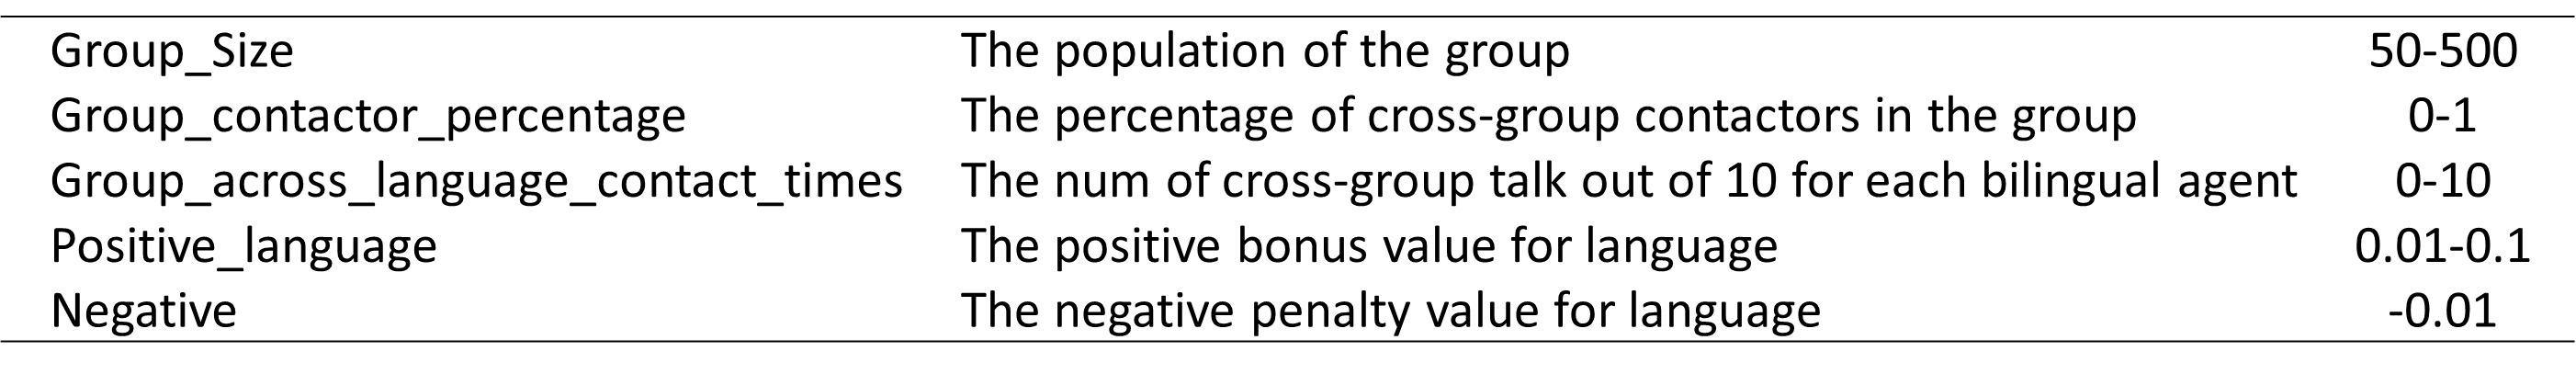

In [4]:
def agent_portrayal(agent):
       if  agent.language_a >= 0.5 and  agent.language_b >= 0.5:
           color = "tab:purple"
       elif agent.language_a >= 0.5:
           color = "tab:blue"
       elif agent.language_b >= 0.5:
           color = "tab:red"
       else:
           color = "tab:gray"
       return {
           "color": color,
           "size": 20,
       }    
model_params = {
       "Alpha_Group": {
           "type": "SliderInt",
           "value": 250,
           "label": "Alpha Group Size:",
           "min": 10,
           "max": 500,
           "step": 10,
       },
       "Beta_Group": {
           "type": "SliderInt",
           "value": 50,
           "label": "Beta Group Size:",
           "min": 10,
           "max": 250,
           "step": 10,
       },
       "Alpha_Group_contactor_percentage": {
           "type": "SliderFloat",
           "value": 0.1,
           "label": "Alpha Group Contactor Percentage:",
           "min": 0.0,
           "max": 1.0,
           "step": 0.1,
       },
       "Beta_Group_contactor_percentage": {
           "type": "SliderFloat",
           "value": 0.1,
           "label": "Beta Group Contactor Percentage:",
           "min": 0.0,
           "max": 1.0,
           "step": 0.1,
       },
       "Alpha_Group_across_language_contact_times": {
           "type": "SliderInt",
           "value": 2,
           "label": "Alpha Across Language Contact Times:",
           "min": 1,
           "max": 9,
           "step": 1,
       },
       "Beta_Group_across_language_contact_times": {
           "type": "SliderInt",
           "value": 8,
           "label": "Beta Across Language Contact Times:",
           "min": 1,
           "max": 9,
           "step": 1,
       },
       "positive_language_a": {
           "type": "SliderFloat",
           "value": 0.05,
           "label": "Positive Language A:",
           "min": 0.01,
           "max": 0.1,
           "step": 0.01,
       },
       "positive_language_b": {
           "type": "SliderFloat",
           "value": 0.05,
           "label": "Positive Language B:",
           "min": 0.01,
           "max": 0.1,
           "step": 0.01,
       },
       "update_method_index": {
           "type": "SliderInt",
           "value": 0,
           "label": "Update Method Index:",
           "min": 0,
           "max": 4,
           "step": 1,
       },
       "negative":-0.01,
       "width": 20,
       "height": 20,
   }
# you can add more measures to monitor
page = JupyterViz(
       LanguageModel,
       model_params,
       measures=["The_user_of_language_a", "The_user_of_language_b"],
       name="Language Model",
       agent_portrayal=agent_portrayal,
   )
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text